# JPX: Tokyo Stock Exchange Prediction
Explore the Tokyo market with your data science skills


※　I think this competition is a competition that ranks the change rate Target of the closing price (Close) between the next day and the 2 days later for each stock on each date.

Understanding what to predict is a bit complicated, so I'd like to take a look at an easy-to-understand example.



In [8]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

# 0.What to predict ? : Take a look at an example of sample submission

In [10]:
sample = pd.read_csv("train_files/stock_prices.csv")
sample

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [3]:
sample.nunique()

Date                56
SecuritiesCode    2000
Rank              2000
dtype: int64

Predict Ranks by date and Securities Code (stocks).

Rank indicates the ranking of the change rate of the closing price (Close) of the next day and the next day for each of 2000 stocks, counting from the largest of 2000 stocks. (If the rate of change is large, it will be to plus direction, so if you buy it for 100 dollar, it will be 120 dollar. If the rate of change is small, it will be large to minus direction, so if you sell it for 100 dollar, it will be 80 dollar. This makes the benefit.)

It's a little difficult to understand, isn't it? Let's take a simple example.

# 1. Understand how to calculate scores and deepen your understanding of Rank

https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

Here is how to calculate the score. It is difficult to understand in mathematical formulas, so I will try to understand them one by one.

Take a look at the train data. stock_prices.csv in train_files

In [4]:
stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [5]:
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])

Of these, Target is important.

# 1.1 Let's look at only one stock

In [6]:
tmpdf = stock_prices[stock_prices["SecuritiesCode"]==1301].reset_index(drop=True)
tmpdf.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092


# Step 1 : Try to calculate TARGET (change rate of Close on the next day and the next day) by yourself.


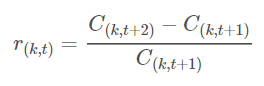

I think open is the price at the beginning of the day, close is the stock price when it closes. So close is the stock price at the end of the day.

In [7]:
tmpdf["Close_shift1"] = tmpdf["Close"].shift(-1)
tmpdf["Close_shift2"] = tmpdf["Close"].shift(-2)

tmpdf["rate"] = (tmpdf["Close_shift2"] - tmpdf["Close_shift1"]) / tmpdf["Close_shift1"]
tmpdf

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Close_shift1,Close_shift2,rate
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2738.0,2740.0,0.000730
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,2740.0,2748.0,0.002920
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,2748.0,2745.0,-0.001092
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,2745.0,2731.0,-0.005100
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,2731.0,2722.0,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,20211129_1301,2021-11-29,1301,2975.0,2984.0,2951.0,2951.0,14300,1.0,NaN,False,0.003793,2900.0,2911.0,0.003793
1198,20211130_1301,2021-11-30,1301,2953.0,2997.0,2900.0,2900.0,20500,1.0,NaN,False,0.007558,2911.0,2933.0,0.007558
1199,20211201_1301,2021-12-01,1301,2909.0,2936.0,2909.0,2911.0,10600,1.0,NaN,False,0.016706,2933.0,2982.0,0.016706
1200,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689,2982.0,NaN,NaN


This understanding is OK because the Target and the rate calculated by myself match. (I will use the Target that is calculated from now on)

# Rank calculation.

First, let's take a look at only one day. * Please note that not all 2000 stocks have data depending on the date.

In [8]:
stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154


In [9]:
tmpdf2 = stock_prices[stock_prices["Date"]=="2021-12-02"].reset_index(drop=True)
tmpdf2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689
1,20211202_1332,2021-12-02,1332,566.0,577.0,565.0,573.0,1525800,1.0,NaN,False,0.006838
2,20211202_1333,2021-12-02,1333,2276.0,2314.0,2267.0,2303.0,157000,1.0,NaN,False,0.008058
3,20211202_1375,2021-12-02,1375,1220.0,1244.0,1209.0,1212.0,121600,1.0,NaN,False,-0.008907
4,20211202_1376,2021-12-02,1376,1353.0,1373.0,1327.0,1327.0,7800,1.0,NaN,False,0.014264
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211202_9990,2021-12-02,9990,518.0,519.0,507.0,507.0,109500,1.0,NaN,False,-0.020833
1996,20211202_9991,2021-12-02,9991,777.0,791.0,775.0,778.0,46600,1.0,NaN,False,-0.011335
1997,20211202_9993,2021-12-02,9993,1672.0,1685.0,1650.0,1650.0,6900,1.0,NaN,False,-0.010942
1998,20211202_9994,2021-12-02,9994,2340.0,2382.0,2340.0,2362.0,9200,1.0,NaN,False,0.012139


Rank in descending order of Target. I do sort it for understanding.
Rank is tied to 0-1999, so don't forget -1 (if you don't enter it, you will get an error)

In [10]:
tmpdf2["rank"] = tmpdf2["Target"].rank(ascending=False,method="first") -1 
tmpdf2 = tmpdf2.sort_values("rank").reset_index(drop=True)

In terms of meaning, the smaller the rank, the larger the rate of change to +, so it is profitable to buy it.
The larger the rank value, the greater the rate of change, so it is profitable to sell it.

# Step 3 Calculation of daily spread return of this day

https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

If you look at, for the top 200 and bottom 200 of the rank, multiply the rate of change target of the closing price you just understood by weight (1 ~ 2). I'm not good at formulas, so I'll calculate it.

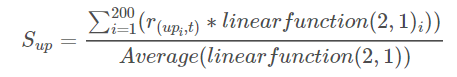

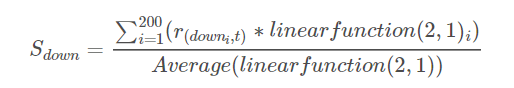

Consider only a rank of 200 from the top. (200 larger Targets)

In [11]:
tmpdf2_top200 = tmpdf2.iloc[:200,:]
tmpdf2_top200

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0
3,20211202_9632,2021-12-02,9632,8110.0,8150.0,8000.0,8030.0,3900,1.0,NaN,False,0.107011,3.0
4,20211202_6958,2021-12-02,6958,510.0,525.0,502.0,517.0,639200,1.0,NaN,False,0.103113,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20211202_6272,2021-12-02,6272,1291.0,1343.0,1291.0,1308.0,23900,1.0,NaN,False,0.012734,195.0
196,20211202_6324,2021-12-02,6324,4500.0,4635.0,4400.0,4490.0,417100,1.0,NaN,False,0.012698,196.0
197,20211202_2899,2021-12-02,2899,1899.0,1919.0,1880.0,1906.0,39400,1.0,NaN,False,0.012697,197.0
198,20211202_2185,2021-12-02,2185,1376.0,1376.0,1355.0,1355.0,200,1.0,NaN,False,0.012687,198.0


Calculate the top 200 weights and embed them in finweights

In [12]:
weights = np.linspace(start=2, stop=1, num=200)
weights

array([2.        , 1.99497487, 1.98994975, 1.98492462, 1.9798995 ,
       1.97487437, 1.96984925, 1.96482412, 1.95979899, 1.95477387,
       1.94974874, 1.94472362, 1.93969849, 1.93467337, 1.92964824,
       1.92462312, 1.91959799, 1.91457286, 1.90954774, 1.90452261,
       1.89949749, 1.89447236, 1.88944724, 1.88442211, 1.87939698,
       1.87437186, 1.86934673, 1.86432161, 1.85929648, 1.85427136,
       1.84924623, 1.84422111, 1.83919598, 1.83417085, 1.82914573,
       1.8241206 , 1.81909548, 1.81407035, 1.80904523, 1.8040201 ,
       1.79899497, 1.79396985, 1.78894472, 1.7839196 , 1.77889447,
       1.77386935, 1.76884422, 1.7638191 , 1.75879397, 1.75376884,
       1.74874372, 1.74371859, 1.73869347, 1.73366834, 1.72864322,
       1.72361809, 1.71859296, 1.71356784, 1.70854271, 1.70351759,
       1.69849246, 1.69346734, 1.68844221, 1.68341709, 1.67839196,
       1.67336683, 1.66834171, 1.66331658, 1.65829146, 1.65326633,
       1.64824121, 1.64321608, 1.63819095, 1.63316583, 1.62814

In [13]:
tmpdf2_top200["weights"] = weights
tmpdf2_top200.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0,2.000000
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0,1.994975
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0,1.989950


Multiply this by target

In [14]:
tmpdf2_top200["calc_weights"] = tmpdf2_top200["Target"] * tmpdf2_top200["weights"]
tmpdf2_top200.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights,calc_weights
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0,2.000000,0.462963
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0,1.994975,0.297757
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0,1.989950,0.244983


The sum of this is divided by weight, Sup


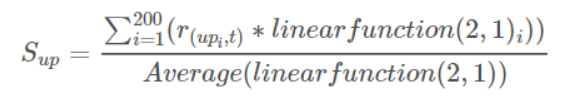


In [15]:
Sup = tmpdf2_top200["calc_weights"].sum()/np.mean(weights)
Sup

5.806640386677844

Similarly, calculate Sdown by calculating 200 bottoms.

In [16]:
tmpdf2_bottom200 = tmpdf2.iloc[-200:,:]
tmpdf2_bottom200 = tmpdf2_bottom200.sort_values("rank",ascending = False).reset_index(drop=True)
tmpdf2_bottom200

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,NaN,False,-0.127424,1999.0
1,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0
2,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0
3,20211202_6879,2021-12-02,6879,731.0,745.0,702.0,707.0,735500,1.0,NaN,False,-0.087248,1996.0
4,20211202_4483,2021-12-02,4483,8200.0,8590.0,8180.0,8410.0,320300,1.0,NaN,False,-0.085480,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20211202_4482,2021-12-02,4482,940.0,972.0,915.0,920.0,111600,1.0,NaN,False,-0.026205,1804.0
196,20211202_7990,2021-12-02,7990,3375.0,3390.0,3290.0,3335.0,114200,1.0,NaN,False,-0.026163,1803.0
197,20211202_6920,2021-12-02,6920,29950.0,30360.0,29540.0,30010.0,4529200,1.0,NaN,False,-0.026036,1802.0
198,20211202_4620,2021-12-02,4620,502.0,511.0,501.0,501.0,53000,1.0,NaN,False,-0.025896,1801.0


In [17]:
tmpdf2_bottom200["weights"] = weights
tmpdf2_bottom200.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights
0,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,NaN,False,-0.127424,1999.0,2.000000
1,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0,1.994975
2,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0,1.989950


In [18]:
tmpdf2_bottom200["calc_weights"] = tmpdf2_bottom200["Target"] * tmpdf2_bottom200["weights"]
tmpdf2_bottom200.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights,calc_weights
0,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,NaN,False,-0.127424,1999.0,2.000000,-0.254848
1,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0,1.994975,-0.189482
2,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0,1.989950,-0.188238


In [19]:
Sdown = tmpdf2_bottom200["calc_weights"].sum()/np.mean(weights)
Sdown

-9.10891259103055

## Calculate daily spread return

In [20]:
daily_spread_return = Sup - Sdown
daily_spread_return

14.915552977708394

This is calculated every day, and the score is calculated by dividing the average value of daily_spread_return for a certain period by the standard deviation.

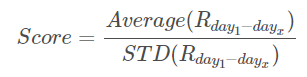

The following functions have put together that. Thank you for preparing.

In [21]:

import numpy as np
import pandas as pd


def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

# 1.2 [Case verification] Score calculation: 

Let's calculate the score of this competition with a function only in 2021 where 2000 stocks are available.

# 1.2.1 Filtering for explanation

In [22]:
idcount = stock_prices.groupby("Date")["SecuritiesCode"].count().reset_index()
idcount

,Date,SecuritiesCode
0,2017-01-04,1865
1,2017-01-05,1865
2,2017-01-06,1865
3,2017-01-10,1865
4,2017-01-11,1865
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


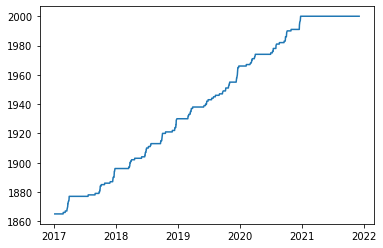

In [23]:
plt.plot(idcount["Date"],idcount["SecuritiesCode"])

Depending on the date, there are cases where there are not 2000 stocks, so only those with 2000 are pulled.

In [24]:
idcount.loc[idcount["SecuritiesCode"]==2000,:]

,Date,SecuritiesCode
970,2020-12-23,2000
971,2020-12-24,2000
972,2020-12-25,2000
973,2020-12-28,2000
974,2020-12-29,2000
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


It seems that 2000 pieces are available from December 23, 2020. For the easy understanding, let's calculate only for 2021.

In [25]:
stock_prices2 = stock_prices.loc[stock_prices["Date"]>= "2021-01-01"].reset_index(drop=True)
stock_prices2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20210104_1301,2021-01-04,1301,2951.0,2951.0,2913.0,2950.0,9700,1.0,NaN,False,0.011502
1,20210104_1332,2021-01-04,1332,428.0,429.0,416.0,421.0,1780500,1.0,NaN,False,0.019093
2,20210104_1333,2021-01-04,1333,2229.0,2231.0,2179.0,2202.0,112400,1.0,NaN,False,0.015075
3,20210104_1375,2021-01-04,1375,1701.0,1701.0,1672.0,1674.0,67900,1.0,NaN,False,-0.003503
4,20210104_1376,2021-01-04,1376,1597.0,1597.0,1577.0,1588.0,4500,1.0,NaN,False,-0.012033
...,...,...,...,...,...,...,...,...,...,...,...,...
451995,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
451996,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
451997,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
451998,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


It seems that you have to prepare Rank yourself. I will put it out in one shot.

In [26]:
stock_prices2["Rank"] = stock_prices2.groupby("Date")["Target"].rank(ascending=False,method="first") -1 
stock_prices2["Rank"] =stock_prices2["Rank"].astype("int") # floatだとエラー

In [27]:
stock_prices2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20210104_1301,2021-01-04,1301,2951.0,2951.0,2913.0,2950.0,9700,1.0,NaN,False,0.011502,655
1,20210104_1332,2021-01-04,1332,428.0,429.0,416.0,421.0,1780500,1.0,NaN,False,0.019093,375
2,20210104_1333,2021-01-04,1333,2229.0,2231.0,2179.0,2202.0,112400,1.0,NaN,False,0.015075,497
3,20210104_1375,2021-01-04,1375,1701.0,1701.0,1672.0,1674.0,67900,1.0,NaN,False,-0.003503,1481
4,20210104_1376,2021-01-04,1376,1597.0,1597.0,1577.0,1588.0,4500,1.0,NaN,False,-0.012033,1737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451995,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,580
451996,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,1119
451997,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,1941
451998,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,1768


In [28]:
stock_prices2["Rank"].min()

0

Calculated below. Portfolio_size is the weight of 200 pieces above and below. toprank_weight_ratio means to multiply evenly spaced weights between 1-2.

In [29]:
score = calc_spread_return_sharpe(stock_prices2, portfolio_size= 200, toprank_weight_ratio= 2)
score

5.790745682567136

And, the score in this period came out. The person with this big wins.

# 2.What do you predict the Rank from? (Look at the data)

First of all, there are many folders, so what does that mean?

* data_specifications : Folder with files that define what the columns in each file mean

* train_files : A data folder that covers the main training period.

* Supplemental_files : Probably, the latest stock price data will be updated in early May, early June, and one week before the end of the competition.

* example_test_files : An example of the file format provided at the time of submit. Since Target is not included, you can calculate by yourself from Close. 

## 2.1 For the time being, let's look only at the contents of the main train_files (the meaning of column shows data_specifications)

### 2.1.1 stock_prices

The core file of interest. Includes the daily closing price for each stock and the target column.

In [30]:
stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154


In [31]:
trades_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv")
trades_spec

,index,Column,Sample value,Type,Addendum,Remarks
0,0,PublishedDate,2017-01-13,date,NaN,"data published data, usually Thursday on the f..."
1,0,StartDate,2017-01-04,date,NaN,The first trading date in this trading week
2,1,EndDate,2017-01-06,date,NaN,The last trading date in this trading week
3,2,Section,Prime Market (First Section),string,NaN,Market division name
4,3,TotalSales,8476800009,Int64,NaN,Please check below documents.\n\nPublished fil...
5,4,TotalPurchases,8483346362,Int64,NaN,NaN
6,5,TotalTotal,16960146371,Int64,NaN,NaN
7,6,TotalBalance,6546353,Int64,NaN,NaN
8,7,ProprietarySales,1311271004,Int64,NaN,NaN
9,8,ProprietaryPurchases,1453326508,Int64,NaN,NaN


### 2.1.2 trades

In [32]:
trades = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/trades.csv")
trades.head(3)

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aggregated summary of trading volumes from the previous business week.

In [33]:
trades_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv")
trades_spec

,index,Column,Sample value,Type,Addendum,Remarks
0,0,PublishedDate,2017-01-13,date,NaN,"data published data, usually Thursday on the f..."
1,0,StartDate,2017-01-04,date,NaN,The first trading date in this trading week
2,1,EndDate,2017-01-06,date,NaN,The last trading date in this trading week
3,2,Section,Prime Market (First Section),string,NaN,Market division name
4,3,TotalSales,8476800009,Int64,NaN,Please check below documents.\n\nPublished fil...
5,4,TotalPurchases,8483346362,Int64,NaN,NaN
6,5,TotalTotal,16960146371,Int64,NaN,NaN
7,6,TotalBalance,6546353,Int64,NaN,NaN
8,7,ProprietarySales,1311271004,Int64,NaN,NaN
9,8,ProprietaryPurchases,1453326508,Int64,NaN,NaN


### 2.1.3 secondary_stock_prices

In [34]:
secondary_stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
secondary_stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900


The core dataset contains on the 2,000 most commonly traded equities but many less liquid securities are also traded on the Tokyo market. This file contains data for those securities, which aren't scored but may be of interest for assessing the market as a whole.

### 2.1.4 options

In [35]:
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
options.head(3)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0


Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly.

In [36]:
options_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/options_spec.csv")
options_spec

,Column,Sample value,Type,Addendum,Remarks
0,DateCode,20170104_144122718,string,NaN,Unique ID for option price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date and time
2,OptionsCode,144122718,string,NaN,Local Securities Code (link to https://www.jpx...
3,WholeDayOpen,0,float,NaN,Opening Price for Whole Trading Day
4,WholeDayHigh,0,float,NaN,High Price for Whole Trading Day
5,WholeDayLow,0,float,NaN,Low Price for Whole Trading Day
6,WholeDayClose,0,float,NaN,Closing Price for Whole Trading Day
7,NightSessionOpen,0,float,NaN,Opening Price for Night Session
8,NightSessionHigh,0,float,NaN,High Price for Night Session
9,NightSessionLow,0,float,NaN,Low Price for Night Session


### 2.1.5 financials

In [37]:
financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
financials.head(3)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,...,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Results from quarterly earnings reports.

In [38]:
stock_fin_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv")
stock_fin_spec

,Column,Sample value,Type,Addendum,Remarks
0,DisclosureNumber,20161025419878,Int64,NaN,Unique ID for disclosure documents.
1,DateCode,20170106_7888,string,NaN,combination of TradeDate and LocalCode (this i...
2,Date,2017-01-06 0:00:00,date,NaN,Trade date. This column is used to align with ...
3,SecuritiesCode,7888,Int64,NaN,Local Securities Code
4,DisclosedDate,2017-01-06 0:00:00,date,NaN,Date on which the document disclosed.
5,DisclosedTime,15:30:00,time,NaN,Time on which the document disclosed.
6,DisclosedUnixTime,1483684200,Int64,NaN,Unix time of the datetime on which the documen...
7,TypeOfDocument,2QFinancialStatements_Consolidated_JP,string,NaN,Document type indicated by ID.
8,CurrentPeriodEndDate,2016-11-30,date,NaN,End date of the current accounting period.
9,TypeOfCurrentPeriod,2Q,date,"[Normal] 1Q (1st Quarter), 2Q (2nd Quarter), 3...",Type of the current accounting period.\n\n[Not...


# 2.2 stocklist : This is separate from the folder

In [39]:
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
stock_list.head(3)

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False


Relationship between Securities Code and company name

In [40]:
stock_list_spec = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_list_spec.csv")
stock_list_spec

,Column,Sample value,Type,Addendum,Remarks
0,SecuritiesCode,1301,Int64,NaN,Local Securities Code
1,EffectiveDate,20211230,date,NaN,the effective date
2,Name,"KYOKUYO CO.,LTD.",string,NaN,Name of security
3,Section/Products,First Section (Domestic),string,NaN,Section/Product
4,NewMarketSegment,Prime Market,string,NaN,New market segment effective from 2022-04-04 (...
5,33SectorCode,50,Int64,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/e...
6,33SectorName,"Fishery, Agriculture and Forestry",string,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/e...
7,17SectorCode,1,Int64,NaN,17 Sector Code\nref. https://www.jpx.co.jp/eng...
8,17SectorName,FOODS,string,NaN,17 Sector Name\nref. https://www.jpx.co.jp/eng...
9,NewIndexSeriesSizeCode,7,Int64,NaN,TOPIX New Index Series code\n\nref. https://ww...


# 3. submit : time series api

time series api is

   Data comes for a certain period (for example, the first day) → Predict it → Submit it


→ Data will come for a certain period (for example, the second day) → Predict it → Submit it


→ Data will come for a certain period (for example, the 3rd day) → Predict it → Submit it


・ ・ ・ It repeats. This time, the submission deadline is 2022 / 7/5. It is said that the winners will be announced on 10/7 with the real data after that.

https://www.kaggle.com/code/sohier/basic-submission-demo

The basic ones are written in.

First do this

In [3]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

ModuleNotFoundError: No module named 'jpx_tokyo_market_prediction.competition'

The following for statement is. For the time being, let's take a look at one dose.

Rewrite Rank in sample_prediction,

Submit once with env.predict,

For the easy understanding, let's break once and see what's going on, but usually we don't break and just let it flow.

In [42]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    break


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [43]:
prices.head(3)

,Date,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
0,2021-12-06,20211206_1301,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False
1,2021-12-06,20211206_1332,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False
2,2021-12-06,20211206_1333,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False


In [44]:
options.head(3)

,Date,DateCode,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,2021-12-06,20211206_130060018,130060018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20250612,20250613,1660.0,1548.5673,22.35085,23.8770,0.1564,0.0,0.0
1,2021-12-06,20211206_130060218,130060218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20250612,20250613,1730.0,1613.2578,22.35085,23.7511,0.1564,0.0,0.0
2,2021-12-06,20211206_130060518,130060518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20250612,20250613,1800.0,1680.2521,22.35085,23.6127,0.1564,0.0,0.0


In [45]:
financials.head(3)

,Date,DisclosureNumber,DateCode,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2021-12-06,2.021121e+13,20211206_1873,1873.0,2021-12-06,15:00:00,1.638770e+09,ForecastRevision,2021-10-31,FY,...,40.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-06,2.021121e+13,20211206_4813,4813.0,2021-12-06,15:00:00,1.638770e+09,3QFinancialStatements_Consolidated_JP,2021-10-31,3Q,...,-77.98,NaN,True,False,False,False,False,39633000.0,466421.0,39095375.0
2,2021-12-06,2.021112e+13,20211206_4824,4824.0,2021-12-06,08:30:00,1.638747e+09,1QFinancialStatements_Consolidated_JP,2021-10-31,1Q,...,3.69,NaN,False,False,False,False,False,9766800.0,23345.0,9743455.0


In [46]:
trades.head(3)

,index,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2021-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
secondary_prices.head(3)

,Date,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag
0,2021-12-06,20211206_1305,1305,2061.5,2065.0,2041.5,2048.0,104900,1.0,NaN,False
1,2021-12-06,20211206_1306,1306,2037.0,2041.0,2018.5,2025.0,1427480,1.0,NaN,False
2,2021-12-06,20211206_1308,1308,2016.0,2019.5,1997.5,2004.5,110000,1.0,NaN,False


In [48]:
sample_prediction.head(3)

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2


Edit and submit sample_prediction.head () here

# 3.1 Trial submit: Submit by substituting all the ranks of the last day as they are.

In [49]:
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


Stock_prices in train_files earlier is up to 2021-12-03.

In [50]:
supplemental_stock_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
supplemental_stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
111995,20220228_9990,2022-02-28,9990,511.0,518.0,509.0,516.0,120600,1.0,NaN,False,-0.013592
111996,20220228_9991,2022-02-28,9991,823.0,825.0,814.0,822.0,16200,1.0,NaN,False,-0.020581
111997,20220228_9993,2022-02-28,9993,1600.0,1622.0,1600.0,1600.0,4000,1.0,NaN,False,0.005762
111998,20220228_9994,2022-02-28,9994,2568.0,2568.0,2540.0,2565.0,9000,1.0,NaN,False,-0.002341


Stock_prices in supplemental_files, which will be updated from time to time, is until 2022-02-28.
I will paste the rank of 2022-02-28 as it is and submit it.

In [51]:
supplemental_stock_prices["Rank"] = supplemental_stock_prices.groupby("Date")["Target"].rank(ascending=False,method="first") -1
supplemental_stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,1394.0
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993,1670.0
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963,1712.0


In [52]:
finday = supplemental_stock_prices[supplemental_stock_prices["Date"]=="2022-02-28"].reset_index(drop=True)
finday

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,NaN,False,-0.007692,514.0
1,20220228_1332,2022-02-28,1332,531.0,545.0,531.0,544.0,2437900,1.0,NaN,False,-0.024209,1293.0
2,20220228_1333,2022-02-28,1333,2474.0,2522.0,2468.0,2515.0,190100,1.0,NaN,False,-0.022106,1199.0
3,20220228_1375,2022-02-28,1375,1189.0,1205.0,1175.0,1201.0,59500,1.0,NaN,False,-0.009909,618.0
4,20220228_1376,2022-02-28,1376,1556.0,1580.0,1555.0,1570.0,12200,1.0,NaN,False,-0.007270,498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20220228_9990,2022-02-28,9990,511.0,518.0,509.0,516.0,120600,1.0,NaN,False,-0.013592,789.0
1996,20220228_9991,2022-02-28,9991,823.0,825.0,814.0,822.0,16200,1.0,NaN,False,-0.020581,1123.0
1997,20220228_9993,2022-02-28,9993,1600.0,1622.0,1600.0,1600.0,4000,1.0,NaN,False,0.005762,136.0
1998,20220228_9994,2022-02-28,9994,2568.0,2568.0,2540.0,2565.0,9000,1.0,NaN,False,-0.002341,333.0


In [53]:
finday[finday["Rank"]==finday["Rank"].iloc[0]]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,NaN,False,-0.007692,514.0


In [54]:
finday["Rank"] = finday["Rank"].astype("int")

Make it into a dictionary

In [55]:
findaydict = dict(zip(finday["SecuritiesCode"],finday["Rank"]))

Edit sample_prediction for submit

In [56]:
sample_prediction.head(3)

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2


In [57]:
sample_prediction["Rank"]  = sample_prediction["SecuritiesCode"].map(findaydict)
sample_prediction

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,514
1,2021-12-06,1332,1293
2,2021-12-06,1333,1199
3,2021-12-06,1375,618
4,2021-12-06,1376,498
...,...,...,...
1995,2021-12-06,9990,789
1996,2021-12-06,9991,1123
1997,2021-12-06,9993,136
1998,2021-12-06,9994,333


Submit once

In [58]:
env.predict(sample_prediction)

## Submit the rest with a for statement 
(For the easy understanding, I broke once in ↑, but usually only the following image)

In [59]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    sample_prediction['Rank'] = sample_prediction["SecuritiesCode"].map(findaydict)
    env.predict(sample_prediction)


In [60]:
sample_prediction

,Date,SecuritiesCode,Rank
0,2021-12-07,1301,514
1,2021-12-07,1332,1293
2,2021-12-07,1333,1199
3,2021-12-07,1375,618
4,2021-12-07,1376,498
...,...,...,...
1995,2021-12-07,9990,789
1996,2021-12-07,9991,1123
1997,2021-12-07,9993,136
1998,2021-12-07,9994,333


# Thank you for reading.